# Enhanced Transformer Anomaly Detection

This notebook demonstrates enhanced transformer anomaly detection with your temperature data.

In [14]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import json
import glob
import os
import warnings
warnings.filterwarnings("ignore")

# Set seeds
np.random.seed(42)
torch.manual_seed(42)

print(f"PyTorch: {torch.__version__}")
device_name = "CUDA" if torch.cuda.is_available() else "CPU"
print(f"Device: {device_name}")

PyTorch: 2.9.1+cu128
Device: CPU


In [15]:
# Enhanced Transformer Model (FIXED)
class EnhancedTransformerAnomalyDetector(nn.Module):
    def __init__(self, input_dim=1, d_model=64, nhead=4, num_layers=2, seq_len=50):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.seq_len = seq_len
        
        # Input projection
        self.input_projection = nn.Linear(input_dim, d_model)
        
        # FIXED positional encoding
        self.register_buffer("pos_encoding", self._create_positional_encoding(seq_len, d_model))
        
        # Feature attention
        if input_dim > 1:
            self.feature_attention = nn.MultiheadAttention(d_model, max(1, nhead//2), batch_first=True)
        
        # Transformer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=d_model*4,
            dropout=0.1, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Variational layers
        self.mu_layer = nn.Linear(d_model, d_model//2)
        self.logvar_layer = nn.Linear(d_model, d_model//2)
        
        # Reconstruction
        self.reconstruction_head = nn.Sequential(
            nn.Linear(d_model//2, d_model),
            nn.ReLU(),
            nn.Linear(d_model, input_dim)
        )
        
        self.attention_weights = None
        
    def _create_positional_encoding(self, seq_len, d_model):
        """Fixed positional encoding"""
        pe = torch.zeros(1, seq_len, d_model)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
        
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                           -(np.log(10000.0) / d_model))
        
        pe[0, :, 0::2] = torch.sin(position * div_term)
        if d_model > 1:
            pe[0, :, 1::2] = torch.cos(position * div_term[:d_model//2])
        
        return pe
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        batch_size, seq_len, features = x.shape
        
        # Project input
        x = self.input_projection(x)
        
        # Add positional encoding
        x = x + self.pos_encoding[:, :seq_len, :]
        
        # Feature attention
        if hasattr(self, "feature_attention") and self.input_dim > 1:
            x_att, att_weights = self.feature_attention(x, x, x)
            x = x + x_att
            self.attention_weights = att_weights
        
        # Transformer
        x = self.transformer(x)
        
        # Variational bottleneck
        mu = self.mu_layer(x)
        logvar = self.logvar_layer(x)
        z = self.reparameterize(mu, logvar)
        
        # Reconstruct
        recon = self.reconstruction_head(z)
        
        return {
            "reconstruction": recon,
            "mu": mu,
            "logvar": logvar,
            "attention": self.attention_weights
        }
    
    def get_anomaly_scores(self, x, outputs):
        recon = outputs["reconstruction"]
        mu = outputs["mu"]
        logvar = outputs["logvar"]
        
        # Reconstruction error
        recon_error = torch.mean((x - recon) ** 2, dim=[1, 2])
        
        # Uncertainty
        uncertainty = torch.mean(torch.exp(logvar), dim=[1, 2])
        
        # Attention score
        att_score = torch.zeros_like(recon_error)
        if outputs["attention"] is not None:
            att_var = torch.var(outputs["attention"], dim=-1)
            att_score = torch.mean(att_var, dim=1)
        
        # Combined
        combined = 0.5 * recon_error + 0.3 * uncertainty + 0.2 * att_score
        
        return {
            "reconstruction_error": recon_error,
            "uncertainty": uncertainty,
            "attention_score": att_score,
            "combined_score": combined
        }

print("✅ Enhanced Transformer model ready!")

✅ Enhanced Transformer model ready!


In [16]:
# Generate training data
def create_training_data(n_samples=1000, seq_len=50, n_features=3):
    time = np.linspace(0, 4*np.pi, n_samples)
    
    f1 = np.sin(time) + 0.1 * time + 0.1 * np.random.randn(n_samples)
    f2 = np.cos(2*time) + 0.1 * np.random.randn(n_samples)
    f3 = 0.5 * np.sin(0.5*time) + 0.1 * np.random.randn(n_samples)
    
    data = np.column_stack([f1, f2, f3])
    
    # Create sequences
    sequences = []
    for i in range(len(data) - seq_len + 1):
        sequences.append(data[i:i+seq_len])
    
    return np.array(sequences)

# Create data
seq_len = 50
n_features = 3
sequences = create_training_data(1500, seq_len, n_features)

# Scale data
scaler = StandardScaler()
sequences_scaled = scaler.fit_transform(sequences.reshape(-1, n_features)).reshape(sequences.shape)

# Split
split = int(0.8 * len(sequences))
train_seqs = sequences_scaled[:split]
test_seqs = sequences_scaled[split:]

print(f"Training: {len(train_seqs)} sequences")
print(f"Test: {len(test_seqs)} sequences")

Training: 1160 sequences
Test: 291 sequences


Training...
Epoch 3: 0.368179
Epoch 6: 0.332814
Epoch 9: 0.287691


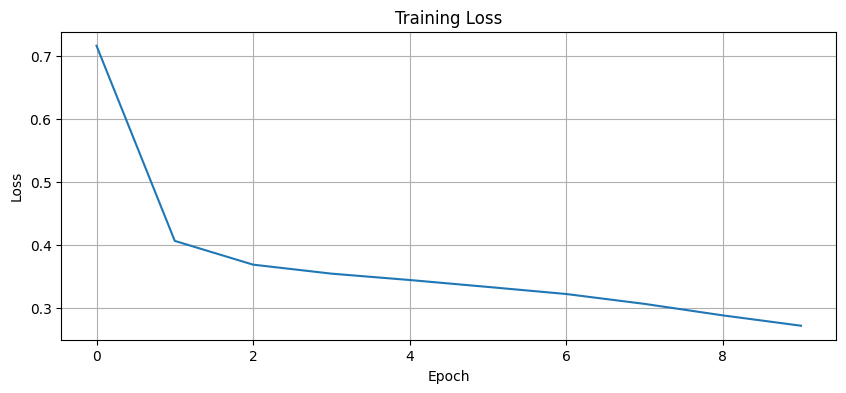

✅ Training complete!


In [17]:
# Train model
def train_model(model, data, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    dataset = TensorDataset(torch.FloatTensor(data))
    loader = DataLoader(dataset, batch_size=32, shuffle=True)
    
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    model.train()
    
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        for batch, in loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            
            outputs = model(batch)
            
            # Loss
            recon_loss = nn.MSELoss()(outputs["reconstruction"], batch)
            kl_loss = -0.5 * torch.sum(1 + outputs["logvar"] - 
                                     outputs["mu"].pow(2) - outputs["logvar"].exp())
            kl_loss /= batch.numel()
            
            loss = recon_loss + 0.1 * kl_loss
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(loader)
        losses.append(avg_loss)
        
        if (epoch + 1) % 3 == 0:
            print(f"Epoch {epoch+1}: {avg_loss:.6f}")
    
    return losses

# Train
model = EnhancedTransformerAnomalyDetector(n_features, 64, 4, 2, seq_len)
print("Training...")
train_losses = train_model(model, train_seqs)

plt.figure(figsize=(10, 4))
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()
print("✅ Training complete!")

In [18]:
# Load your temperature data
def load_temperature_data():
    data_dir = "/home/lokman/Desktop/projects/dezem/transformeranomalygen/assets/data/timeseries-data/nodes/"
    print(f"Loading from: {data_dir}")
    
    files = glob.glob(os.path.join(data_dir, "*.json"))
    print(f"Found {len(files)} files")
    
    all_data = {}
    names = []
    
    for file_path in files[:5]:  # First 5 files
        try:
            with open(file_path, "r", encoding="utf-8") as f:
                data = json.load(f)
            
            name = data["node"]["sName"]
            names.append(name)
            
            # Extract data
            curve_data = data["data"]["oCurveData"]["oData"]
            series_key = list(curve_data.keys())[0]
            series_data = curve_data[series_key]["mResult"]
            
            # Get values
            values = []
            timestamps = []
            for ts_str, val_data in series_data.items():
                timestamps.append(int(ts_str))
                val = val_data[0] if isinstance(val_data, list) else val_data
                values.append(val)
            
            # Sort
            sorted_data = sorted(zip(timestamps, values))
            _, values = zip(*sorted_data)
            
            all_data[name] = list(values)
            print(f"  {name}: {len(values)} points")
            
        except Exception as e:
            print(f"  Error: {e}")
            continue
    
    if not all_data:
        print("No data loaded - creating dummy data")
        # Dummy data
        n_points = 168
        temps = []
        for i in range(n_points):
            temp = 5 + 3 * np.sin(2 * np.pi * i / 24) + np.random.normal(0, 0.5)
            temps.append(temp)
        # Add anomalies
        temps[50] += 10
        temps[120] -= 8
        all_data["Dummy"] = temps
        names = ["Dummy"]
    
    # Combine
    min_len = min(len(v) for v in all_data.values())
    combined = []
    for name in names:
        if name in all_data:
            combined.append(all_data[name][:min_len])
    
    combined = np.array(combined).T
    print(f"Combined shape: {combined.shape}")
    
    return combined, names

# Load data
temp_data, temp_names = load_temperature_data()

Loading from: /home/lokman/Desktop/projects/dezem/transformeranomalygen/assets/data/timeseries-data/nodes/
Found 12 files
  Hamburg (EDDH): 169 points
  Kassel (EDVK): 169 points
  Temperatur innen über HR: 169 points
  Nürnberg: 169 points
  Kiel-Holtenau (EDHK): 169 points
Combined shape: (169, 5)


In [19]:
# Analyze your temperature data
def analyze_temperature_data(data, names, model, scaler):
    print("Analyzing your temperature data...")
    
    # Adjust features
    if data.shape[1] != n_features:
        print(f"Adjusting features: {data.shape[1]} -> {n_features}")
        if data.shape[1] < n_features:
            pad = np.zeros((data.shape[0], n_features - data.shape[1]))
            data = np.concatenate([data, pad], axis=1)
        else:
            data = data[:, :n_features]
    
    # Scale
    data_scaled = scaler.transform(data)
    
    # Create sequences
    sequences = []
    indices = []
    for i in range(len(data_scaled) - seq_len + 1):
        sequences.append(data_scaled[i:i+seq_len])
        indices.append(i + seq_len - 1)
    
    sequences = np.array(sequences)
    print(f"Created {len(sequences)} sequences")
    
    # Detect anomalies
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    
    with torch.no_grad():
        tensor = torch.FloatTensor(sequences).to(device)
        outputs = model(tensor)
        scores = model.get_anomaly_scores(tensor, outputs)
        
        # Convert to numpy
        all_scores = {}
        for k, v in scores.items():
            all_scores[k] = v.cpu().numpy()
    
    # Threshold
    threshold = np.percentile(all_scores["combined_score"], 95)
    predictions = (all_scores["combined_score"] > threshold).astype(int)
    
    print("Results:")
    print(f"  Sequences: {len(predictions)}")
    print(f"  Anomalies: {np.sum(predictions)}")
    print(f"  Rate: {np.mean(predictions):.1%}")
    print(f"  Threshold: {threshold:.4f}")
    
    return data, sequences, all_scores, predictions, threshold, indices

# Analyze
temp_data_adj, temp_seqs, temp_scores, temp_preds, temp_thresh, temp_indices = analyze_temperature_data(temp_data, temp_names, model, scaler)

Analyzing your temperature data...
Adjusting features: 5 -> 3
Created 120 sequences
Results:
  Sequences: 120
  Anomalies: 6
  Rate: 5.0%
  Threshold: 215.3635


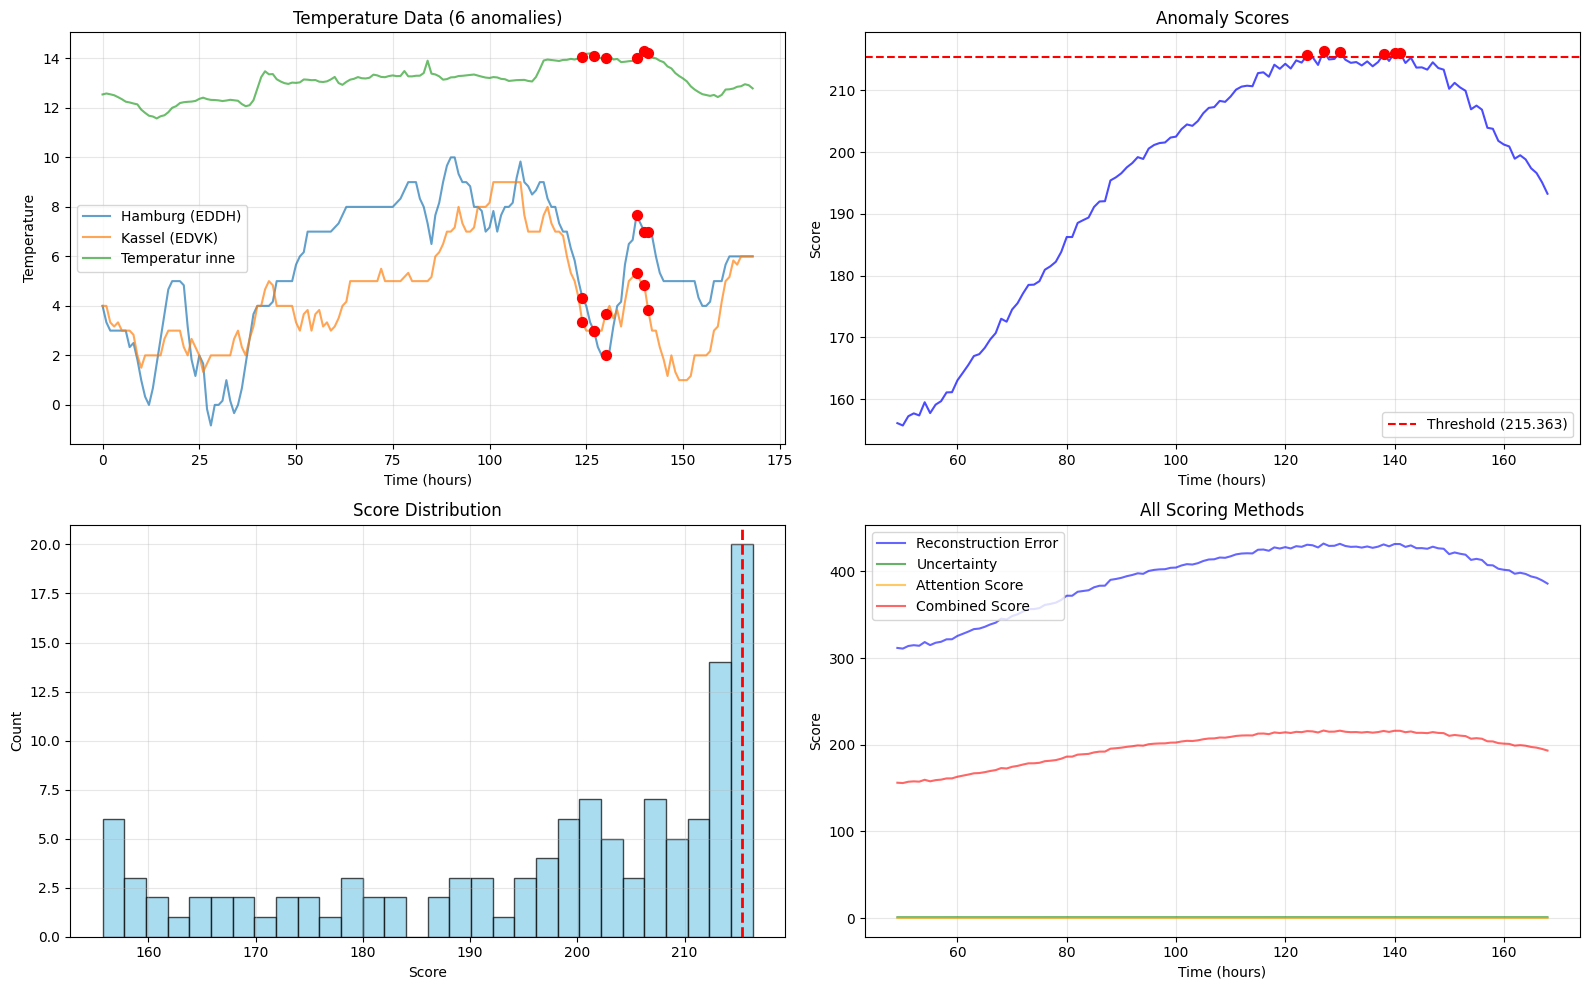

Analysis complete!
Anomalies at hours: [np.int64(124), np.int64(127), np.int64(130), np.int64(138), np.int64(140), np.int64(141)]
Sensors: ['Hamburg (EDDH)', 'Kassel (EDVK)', 'Temperatur innen über HR']...


In [20]:
# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Temperature data with anomalies
ax1 = axes[0, 0]
n_plot = min(3, temp_data_adj.shape[1])
for i in range(n_plot):
    name = temp_names[i] if i < len(temp_names) else f"Feature {i+1}"
    ax1.plot(temp_data_adj[:, i], alpha=0.7, label=name[:15])

# Mark anomalies
anom_pos = np.array(temp_indices)[temp_preds == 1]
if len(anom_pos) > 0:
    for i in range(n_plot):
        ax1.scatter(anom_pos, temp_data_adj[anom_pos, i], 
                   color="red", s=50, zorder=5)

ax1.set_title(f"Temperature Data ({np.sum(temp_preds)} anomalies)")
ax1.set_xlabel("Time (hours)")
ax1.set_ylabel("Temperature")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Scores
ax2 = axes[0, 1]
combined = temp_scores["combined_score"]
ax2.plot(temp_indices, combined, "b-", alpha=0.7)
ax2.axhline(temp_thresh, color="red", linestyle="--", 
           label=f"Threshold ({temp_thresh:.3f})")
if len(anom_pos) > 0:
    ax2.scatter(anom_pos, combined[temp_preds == 1], 
               color="red", s=50, zorder=5)
ax2.set_title("Anomaly Scores")
ax2.set_xlabel("Time (hours)")
ax2.set_ylabel("Score")
ax2.legend()
ax2.grid(True, alpha=0.3)

# Distribution
ax3 = axes[1, 0]
ax3.hist(combined, bins=30, alpha=0.7, color="skyblue", edgecolor="black")
ax3.axvline(temp_thresh, color="red", linestyle="--", linewidth=2)
ax3.set_title("Score Distribution")
ax3.set_xlabel("Score")
ax3.set_ylabel("Count")
ax3.grid(True, alpha=0.3)

# All methods
ax4 = axes[1, 1]
methods = ["reconstruction_error", "uncertainty", "attention_score", "combined_score"]
colors = ["blue", "green", "orange", "red"]
for method, color in zip(methods, colors):
    scores = temp_scores[method]
    ax4.plot(temp_indices, scores, alpha=0.6, color=color, 
            label=method.replace("_", " ").title())
ax4.set_title("All Scoring Methods")
ax4.set_xlabel("Time (hours)")
ax4.set_ylabel("Score")
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Analysis complete!")
if np.sum(temp_preds) > 0:
    print(f"Anomalies at hours: {list(anom_pos)}")
    print(f"Sensors: {temp_names[:3]}...")
else:
    print("No anomalies detected.")